In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.patches as patch
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Introducción.

- En este notebook, encontraremos lineas de código para analizar los juegos de la Máquina Cemetera del Cruz Azul.
    - Las fuentes de datos es un archivo csv que he extraje de Fivethirtyeight y al cual añadí los disparos totales con ayuda de Fbref.com
    - Para utilizarlo pueden descargar el archivo a su equipo o usar la liga que proporcionar en las primeras líneas de comandos

In [2]:
# liga donde obtendremos los datos del archivo

link = 'https://raw.githubusercontent.com/EduardoSanchezZ/Proyecto-Sports-Analytics/main/Data/Cruz%20Azul/Juegos_de_Cruz_Azul.csv'
data = pd.read_csv(link)

#Output

data.tail(5)

,ID_Partido,Ciclo,Torneo,ID_Torneo,Fecha,Fase,Condicion,DT,Rival,Pts_pronosticados,Goles_anotados,Goles_recibidos,Disparos_realizados,Disparos_permitidos,xGF,xGC,xJG,xJE,xJP
220,221,2022-23,A-22,12,2022-09-18,REG,Visita,Raul Gutierrez,Pumas Unam,1.34,2,1,11,22,1.82,1.95,0.36,0.23,0.41
221,222,2022-23,A-22,12,2022-10-01,REG,Local,Raul Gutierrez,Guadalajara,1.41,2,1,13,14,0.95,0.65,0.42,0.35,0.24
222,223,2022-23,A-22,12,2022-10-08,LIG,Local,Raul Gutierrez,León,1.85,1,0,19,13,2.39,0.70,0.76,0.16,0.08
223,224,2022-23,A-22,12,2022-10-12,LIG,Local,Raul Gutierrez,Monterrey,1.15,0,0,9,7,0.36,0.82,0.15,0.40,0.46
224,225,2022-23,A-22,12,2022-10-15,LIG,Visita,Raul Gutierrez,Monterrey,0.68,0,3,20,15,2.67,1.86,0.55,0.20,0.25


# Variables del dataset

    - ID_Partido: Número de partido de la base de datos
    - Ciclo: Año futbolístico (temporada)
    - Torneo: Nombre del torneo
    - Fecha: Fecha del juego
    - Fase: Regular o Liguilla
    - Condición: Local o visitante
    - DT: Director Técnico
    - Rival: Equipo al que se enfrentan 
    - Pts_pronosticados: Proyección de Fivethirtyeight
    - Goles_anotados: Goles anotados en el partido
    - Goles_recibidos: Goles recibidos en el partido
    - Disparos_realizados: Disparos realizados por jugadores de Cruz Azul
    - Disparos_permitidos: Disparos realizados por jugadores rivales
    - xGF: Probabilidad acumulada de que los disparos de Cruz Azul terminen en gol 
    - xGC: Probabilidad acumulada de que los disparos rivales terminen en gol
    - xJG, xJE, xJP: Haciendo una simulación, calculamos la probabilidad de que Cruz Azul gané, empate o pierda

# Agrupación por DT
    - Uno de los análisis más frecuentes es el analizar el desempeño del equipo desglosado por Director Técnico

In [3]:
# Creamos un dataframe nuevo

df = data.copy()

# Agregamos variables para victorias, derrotas, empates y puntos

df['jg'] = np.where(df['Goles_anotados']>df['Goles_recibidos'],1,0)
df['je'] = np.where(df['Goles_anotados']==df['Goles_recibidos'],1,0)
df['jp'] = np.where(df['Goles_anotados']<df['Goles_recibidos'],1,0)
df['pts'] = np.where(df['Goles_anotados']>df['Goles_recibidos'],3,np.where(df['Goles_anotados']<df['Goles_recibidos'],0,1))
df['xpts'] = df['xJG'] * 3 + df['xJE']

# Agrupamos por Director Técnico (DT), debido a que hay diferentes muestras de juegos, utilizaremos medias

dt_agg = df.groupby(['DT']).agg(juegos = ('Fecha', 'count'),
                              exp_jg = ('xJG', 'sum'),
                              exp_je = ('xJE', 'sum'),
                              exp_jp = ('xJP', 'sum'),
                              exp_pts_prom = ('xpts', 'mean'),
                              ganados = ('jg', 'sum'),
                              empates = ('je', 'sum'),
                              derrotas = ('jp', 'sum'),
                              pts_prom = ('pts', 'mean')).reset_index().sort_values(by=['juegos'], ascending=[False])

dt_agg['exp_jg'] = round(dt_agg['exp_jg'],1)
dt_agg['exp_je'] = round(dt_agg['exp_je'],1)
dt_agg['exp_jp'] = round(dt_agg['exp_jp'],1)
dt_agg['exp_pts_prom'] = round(dt_agg['exp_pts_prom'],3)
dt_agg['pts_prom'] = round(dt_agg['pts_prom'],3)

dt_agg = dt_agg.reset_index(drop=True)

dt_agg.index = dt_agg.index + 1

#Output

# Mensaje 
print("Desempeño de Cruz Azul, desglosado por Director Téçnico:")

dt_agg

Desempeño de Cruz Azul, desglosado por Director Téçnico:


,DT,juegos,exp_jg,exp_je,exp_jp,exp_pts_prom,ganados,empates,derrotas,pts_prom
1,Pedro Caixinha,67,28.2,17.6,21.2,1.526,29,22,16,1.627
2,Juan Reynoso,61,23.9,17.0,20.0,1.456,29,17,15,1.705
3,Robert Siboldi,41,18.4,9.4,13.1,1.576,21,7,13,1.707
4,Francisco Jemez,36,16.0,10.5,9.5,1.623,12,14,10,1.389
5,Diego Aguirre,10,2.6,2.4,5.0,1.025,2,2,6,0.800
6,Raul Gutierrez,10,4.2,2.4,3.4,1.511,6,2,2,2.000


In [62]:
df[df['Fecha']<'2018-05-30'].groupby('Torneo').sum()

,ID_Partido,ID_Torneo,Pts_pronosticados,Goles_anotados,Goles_recibidos,Disparos_realizados,Disparos_permitidos,xGF,xGC,xJG,xJE,xJP,jg,je,jp,pts,xpts
Torneo,,,,,,,,,,,,,,,,,
A-17,513,38,27.66,22,22,256,201,25.9,19.30,8.41,5.07,5.50,7,8,4,29,30.30
C-17,153,17,23.60,19,20,254,157,20.1,13.66,7.57,5.42,4.03,5,6,6,21,28.13
C-18,765,51,25.04,22,18,219,214,25.7,19.87,7.58,4.15,5.27,5,7,5,22,26.89


# Desempeño en las áreas
  
   ## Apertura 2022
     
     - El Apertura 2022, fue un torneo contrastante para la Máquina; el torneo lo inició con Diego Aguirre como DT, el cuál fue despedido tras perder el Clásico Joven por 7-0 y acumular sólo 8 puntos en 10 fechas. Una defensa históricamente mala, tanto en prevención de disparos en contra, los cuales tuvieron la probabilidad más alta de terminar en gol desde el Clausura 2017, como en el desempeño en la portería (Sebastián Jurado, tuvo actuaciones cuestionables); a esos factores hay que gregar la partida del centro delantero titular (Santiago Giménez) tras sólo 5 partidos y la llegada tardía de refuerzos (Rogelio Funes Mori, Michael Estrada y Alonso Escoboza). 
     
     
     - A partir de la fecha 11, Raaúl Gutiérrez tomó las riendas del equipo y el equipo cosechó 5 victorias, 1 empate y 1 derrota en la fase regular, consiguiendo la entrada a l liguilla vía reclasificación como el sembrado número 7; hagamos un comparativo sencillo, entre ambos períodos.

In [4]:
# Desempeño con los disparos:

xg_agg = df.groupby(['DT']).agg(juegos = ('Fecha', 'count'),
                              disp_favor = ('Disparos_realizados', 'sum'),
                              xG_favor = ('xGF', 'sum'), 
                              Goles_favor = ('Goles_anotados', 'sum'),  
                              disp_contra = ('Disparos_permitidos', 'sum'),
                              xG_contra = ('xGC', 'sum'),
                              Goles_contra = ('Goles_recibidos', 'sum'),
                              xG_Pts = ('xpts', 'sum'),
                              Pts = ('pts', 'sum')).reset_index().sort_values(by='juegos', ascending=[False])


# Reajustamos el indice

xg_agg = xg_agg.reset_index(drop=True)
xg_agg.index = xg_agg.index + 1

# Output:

print("Disparos por partido: probabilidades y realidades.")

round(xg_agg[xg_agg['DT'].isin(['Diego Aguirre', 'Raul Gutierrez'])].set_index('DT').transpose(), 2)

Disparos por partido: probabilidades y realidades.


DT,Diego Aguirre,Raul Gutierrez
juegos,10.00,10.00
disp_favor,118.00,127.00
xG_favor,11.65,15.61
Goles_favor,12.00,15.00
disp_contra,146.00,114.00
xG_contra,17.34,12.30
Goles_contra,25.00,12.00
xG_Pts,10.25,15.11
Pts,8.00,20.00


# Desempeño en la áreas (pt. II)

  ##  Interinato de Raúl Gutiérrez:
  
- Contrastando con el período de Diego Aguirre, Cruz Azul en los 10 juegos que dirigió Raúl Gutiérrez:
  


  - Ofensiva:
    - Intentó 9 tiros más en el período.
    - Produjó 3.96 más goles esperados.
    - Si bien, su desempeño esperado fue superior al observado, anotó 3 goles más.
    
    
    
  - Defensiva:
    - Hubó un cambio en la formación; del 4-2-3-1 del charrúa al 5-3-2 del Potro.
    - Permitieron 32 disparos menos.
    - Concedieron 5 goles esperados menos (17.34 vs 12.30):
        - La probabilidad de gol por disparo se redujo de 11.9% a 10.8%
    - Permitieron 13 goles menos:
        - El rendimiento en la portería mejoró sustancialmente; pasron de permitir 7.66 goles más de lo esperado a conceder 0.3 menos de lo esperado.
        
        
        
- Los números indican una mejora tanto ofensiva, intentando más disparos, con mayores probabilidades de terminar en gol; como defensiva, donde permitieron menos disparos, con menos probabilidades de terminar en gol y donde su rendiminto en el área paso de pésimo a promedio; sin embargo, haciendo las simulaciones nos arrojan que el equipo tuvo un desemepeño muy por encima de lo esperado.
    - Mientras que en el período de Diego Aguirre se tuvieron 10.25 pts esperados (malo) y su rendimiento observado fue de 8 pts (peor), en la gestión de Raúl Gutiérrez se obtuviero 20 puntos desde 15.11 esperados.

    
    
- Como se compara contra los otros torneos y que tan sustentable es ser tan eficiente.

In [7]:
# Desempeño con los disparos:

xg_tor = df.groupby(['ID_Torneo', 
                     'Torneo',
                     'DT']).agg(juegos = ('Fecha', 'count'),
                                disp_favor = ('Disparos_realizados', 'sum'),
                                xG_favor = ('xGF', 'sum'),
                                Goles_favor = ('Goles_anotados', 'sum'),
                                disp_contra = ('Disparos_permitidos', 'sum'),
                                xG_contra = ('xGC', 'sum'),
                                Goles_contra = ('Goles_recibidos', 'sum'),
                                xG_Pts = ('xpts', 'sum'),
                                Pts = ('pts', 'sum')).reset_index().sort_values(by='ID_Torneo', ascending=[True])

# Variable de diferencia de puntos

xg_tor['POE'] = round((xg_tor['Pts'] - xg_tor['xG_Pts'])/xg_tor['juegos'], 2)


# Reajustamos el indice

xg_tor = xg_tor.reset_index(drop=True)
xg_tor.index = xg_tor.index + 1

# Output

xg_tor

# Analicemos más a detalle el período 2018-19, 2020 y 2021

,ID_Torneo,Torneo,DT,juegos,disp_favor,xG_favor,Goles_favor,disp_contra,xG_contra,Goles_contra,xG_Pts,Pts,POE
1,1,C-17,Francisco Jemez,17,254,20.10,19,157,13.66,20,28.13,21,-0.42
2,2,A-17,Francisco Jemez,19,256,25.90,22,201,19.30,22,30.30,29,-0.07
3,3,C-18,Pedro Caixinha,17,219,25.70,22,214,19.87,18,26.89,22,-0.29
4,4,A-18,Pedro Caixinha,23,245,23.09,30,265,24.63,17,29.19,44,0.64
5,5,C-19,Pedro Caixinha,19,242,25.77,28,192,16.36,18,32.44,33,0.03
6,6,A-19,Pedro Caixinha,8,118,11.34,10,90,7.70,10,13.70,10,-0.46
7,6,A-19,Robert Siboldi,10,157,13.22,15,104,9.79,14,16.05,13,-0.31
8,7,C-20,Robert Siboldi,10,134,16.83,24,146,14.16,14,15.51,22,0.65
9,8,G-20,Robert Siboldi,21,329,31.00,30,255,24.85,22,33.06,35,0.09
10,9,G-21,Juan Reynoso,23,281,25.91,33,251,21.12,15,35.16,52,0.73


Métricas del Apertura 2018
Goles esperados a favor: 23.09 Goles esperados en contra: 24.63
Goles a favor 30 Goles en contra 17
Puntos esperados: 1.27 Puntos obtenidos: 1.91 

Métricas del Clausura 2019
Goles esperados a favor: 25.77 Goles esperados en contra: 16.36
Goles a favor 28 Goles en contra 18
Puntos esperados: 1.71 Puntos obtenidos: 1.74


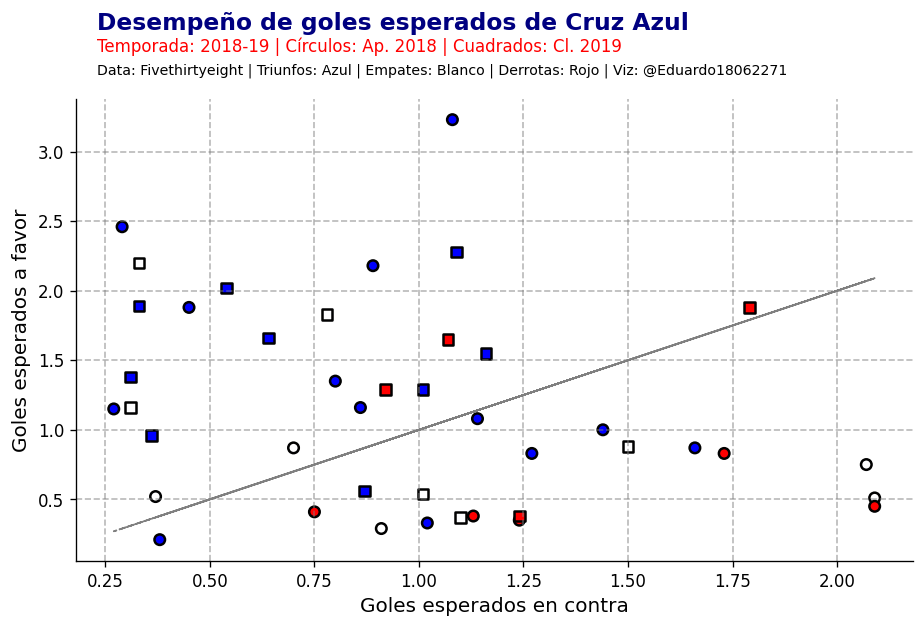

In [8]:
# Período 2018-19

#Figura donde se insertara la grafica
fig= plt.figure(figsize= (9,5), dpi= 120)
ax= plt.subplot(111, facecolor= "white")

# Formato del contorno de figura y líneas de división de ejes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(lw = 1, color = "grey", ls='--', alpha=0.55)


g = df[df['Torneo'].isin(['A-18', 'C-19'])].sort_values(by='ID_Partido').reset_index(drop=True)
g.index = g.index+1

x = g[g['Torneo']=='A-18']['xGC']
y = g[g['Torneo']=='A-18']['xGF']
z = g[g['Torneo']=='A-18']['jg']*2 + g[g['Torneo']=='A-18']['je']

ax.scatter(x, y, c=z, ec='black', lw=1.5, s=40, marker='o', cmap= 'bwr_r')


x1 = g[g['Torneo']=='C-19']['xGC']
y1 = g[g['Torneo']=='C-19']['xGF']
z1 = g[g['Torneo']=='C-19']['jg']*2 + g[g['Torneo']=='C-19']['je']

ax.scatter(x1, y1, c=z1, ec='black', lw=1.5, s=40, marker='s', cmap= 'bwr_r')


ax.plot(x,x, ls='--', lw=1, color='grey')

ax.set_ylabel('Goles esperados a favor', fontsize = 12)
ax.set_xlabel('Goles esperados en contra', fontsize =12)

ax.text(x.min()*0.85, y.max()*1.2, s='Desempeño de goles esperados de Cruz Azul', fontsize=14, fontweight='bold', color='navy')
ax.text(x.min()*0.85, y.max()*1.15, s='Temporada: 2018-19 | Círculos: Ap. 2018 | Cuadrados: Cl. 2019', fontsize=10, color='red')
ax.text(x.min()*0.85, y.max()*1.10, s='Data: Fivethirtyeight | Triunfos: Azul | Empates: Blanco | Derrotas: Rojo | Viz: @Eduardo18062271', fontsize=8.5, color='black')

# Métricas Apertura 2018
print("Métricas del Apertura 2018")
print("Goles esperados a favor:", g[g['Torneo']=='A-18']['xGF'].sum(),"Goles esperados en contra:", g[g['Torneo']=='A-18']['xGC'].sum())
print("Goles a favor", g[g['Torneo']=='A-18']['Goles_anotados'].sum(),"Goles en contra", g[g['Torneo']=='A-18']['Goles_recibidos'].sum())
print("Puntos esperados:", round(g[g['Torneo']=='A-18']['xpts'].mean(),2),"Puntos obtenidos:", round(g[g['Torneo']=='A-18']['pts'].mean(),2),"\n")

# métrica Clausura 2019
print("Métricas del Clausura 2019")
print("Goles esperados a favor:", g[g['Torneo']=='C-19']['xGF'].sum(),"Goles esperados en contra:", g[g['Torneo']=='C-19']['xGC'].sum())
print("Goles a favor", g[g['Torneo']=='C-19']['Goles_anotados'].sum(),"Goles en contra", g[g['Torneo']=='C-19']['Goles_recibidos'].sum())
print("Puntos esperados:", round(g[g['Torneo']=='C-19']['xpts'].mean(),2),"Puntos obtenidos:", round(g[g['Torneo']=='C-19']['pts'].mean(),2))


Text(0, 0.5, 'Puntos por período')

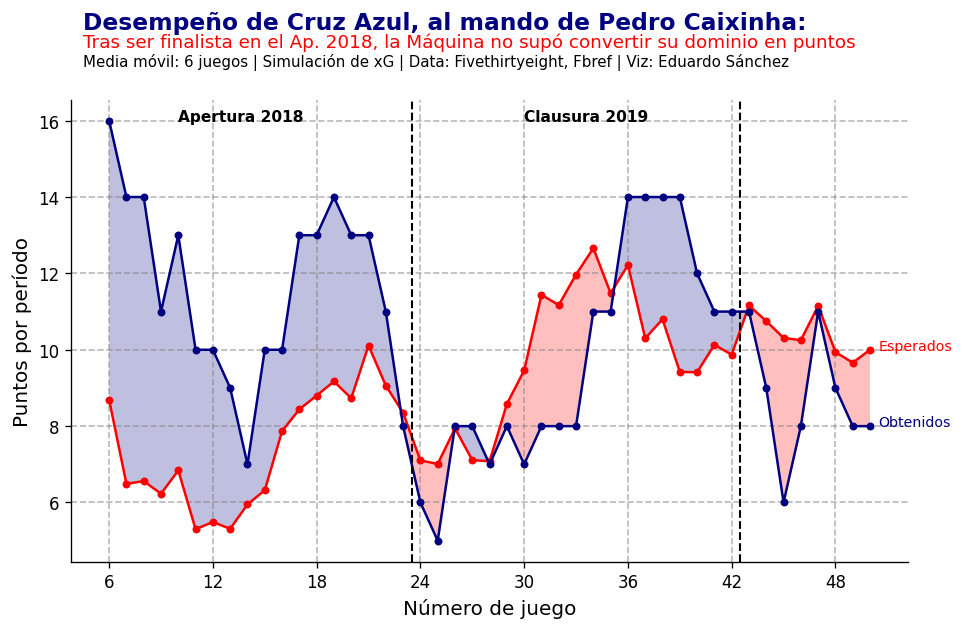

In [53]:
# Período 2018-19

#Figura donde se insertara la grafica
fig= plt.figure(figsize= (9,5), dpi= 120)
ax= plt.subplot(111, facecolor= "white")

# Formato del contorno de figura y líneas de división de ejes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

# Promedio por partido

# Puntos esperados en el período del Aprtura 2018 al despido de Pedro Caixinha

y = df[(df['Torneo'].isin(['A-18', 'C-19','A-19']))&(df['Fecha']<='2019-08-31')]['xpts'].rolling(window=6).sum()
y = y[~(np.isnan(y))].reset_index(drop=True)
y.index = y.index+6

# Calculamos la variable x
x = pd.Series(range(len(y)))+6

# Gráfico de puntos esperados

ax.plot(x,y, lw=1.5, marker='o', ms=3.75, color='red')

# Puntos obtenidos en el período del Apertura 2018 al despido de Pedro Caixinha

y1 = df[(df['Torneo'].isin(['A-18', 'C-19','A-19']))&(df['Fecha']<='2019-08-31')]['pts'].rolling(window=6).sum()
y1 = y1[~(np.isnan(y1))].reset_index(drop=True)
y1.index = y1.index+6

# Gráfico de puntos obtenidos

ax.plot(x,y1, lw=1.5, marker='o', ms=3.75, color='navy')

# Relleno de las gráficas

ax.fill_between(x,
                y, 
                y1, where= y< y1,
                facecolor= 'navy', 
                alpha=0.25,
                interpolate=True)
ax.fill_between(x,
                y, 
                y1, 
                where= y>=y1,
                facecolor='red', 
                alpha=0.25,
                interpolate=True)

# Texto para identificar las líneas

ax.text(x.iloc[-1]+0.5, y.iloc[-1]-0.015, s='Esperados', fontsize=8.5, color='red')

ax.text(x.iloc[-1]+0.5, y1.iloc[-1], s='Obtenidos', fontsize=8.5, color='navy')


# Título del gráfico

ax.text(x.min()*0.75, y1.max()*1.15, s='Desempeño de Cruz Azul, al mando de Pedro Caixinha:', fontsize=14, color='navy', fontweight='bold')

# Subtítulo

ax.text(x.min()*0.75, y1.max()*1.12, s='Tras ser finalista en el Ap. 2018, la Máquina no supó convertir su dominio en puntos', fontsize=11, color='red')

#Referencias

ax.text(x.min()*0.75, y1.max()*1.09, s='Media móvil: 6 juegos | Simulación de xG | Data: Fivethirtyeight, Fbref | Viz: Eduardo Sánchez', fontsize=9, color='black')


# Línea divisora de torneos
ax.axvline(23.5, ls='--', lw=1.25, color='black')
ax.axvline(42.5, ls='--', lw=1.25, color='black')

# Ajuste de los parametros del eje x

ax.set_xticks(np.arange(6, 51, 6))


# Texto para identificar torneos

ax.text(10,16, s='Apertura 2018', fontsize=9.25, color='black', fontweight='bold')
ax.text(30,16, s='Clausura 2019', fontsize=9.25, color='black', fontweight='bold')

# Títulos de eje

ax.set_xlabel('Número de juego', fontsize=12)
ax.set_ylabel('Puntos por período', fontsize=12)

Text(0, 0.5, 'Puntos por período')

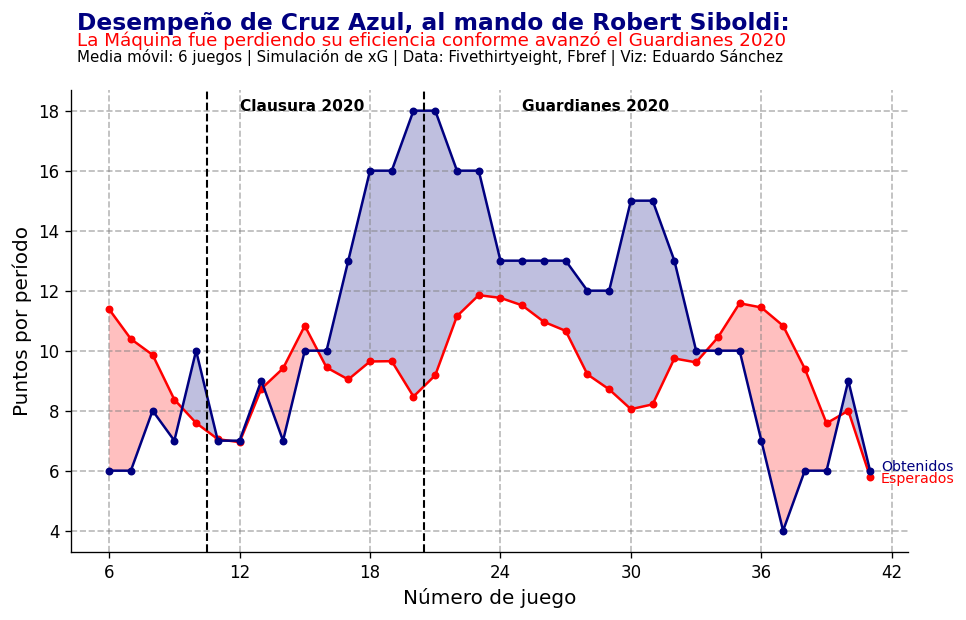

In [54]:
# Período 2018-19

#Figura donde se insertara la grafica
fig= plt.figure(figsize= (9,5), dpi= 120)
ax= plt.subplot(111, facecolor= "white")

# Formato del contorno de figura y líneas de división de ejes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

# Promedio por partido

# Puntos esperados en el período del Aprtura 2018 al despido de Pedro Caixinha

y = df[(df['Torneo'].isin(['A-19', 'C-20', 'G-20']))&(df['Fecha']>'2019-08-31')]['xpts'].rolling(window=6).sum()
y = y[~(np.isnan(y))].reset_index(drop=True)
y.index = y.index+6

# Calculamos la variable x
x = pd.Series(range(len(y)))+6

# Gráfico de puntos esperados

ax.plot(x,y, lw=1.5, marker='o', ms=3.75, color='red')

# Puntos obtenidos en el período del Apertura 2018 al despido de Pedro Caixinha

y1 = df[(df['Torneo'].isin(['A-19', 'C-20', 'G-20']))&(df['Fecha']>'2019-08-31')]['pts'].rolling(window=6).sum()
y1 = y1[~(np.isnan(y1))].reset_index(drop=True)
y1.index = y1.index+6

# Gráfico de puntos obtenidos

ax.plot(x,y1, lw=1.5, marker='o', ms=3.75, color='navy')

# Relleno de las gráficas

ax.fill_between(x,
                y, 
                y1, where= y< y1,
                facecolor= 'navy', 
                alpha=0.25,
                interpolate=True)
ax.fill_between(x,
                y, 
                y1, 
                where= y>=y1,
                facecolor='red', 
                alpha=0.25,
                interpolate=True)

# Texto para identificar las líneas

ax.text(x.iloc[-1]+0.5, y.iloc[-1]-0.2, s='Esperados', fontsize=8.5, color='red')

ax.text(x.iloc[-1]+0.5, y1.iloc[-1], s='Obtenidos', fontsize=8.5, color='navy')


# Título del gráfico

ax.text(x.min()*0.75, y1.max()*1.15, s='Desempeño de Cruz Azul, al mando de Robert Siboldi:', fontsize=14, color='navy', fontweight='bold')

# Subtítulo

ax.text(x.min()*0.75, y1.max()*1.12, s='La Máquina fue perdiendo su eficiencia conforme avanzó el Guardianes 2020', fontsize=11, color='red')

#Referencias

ax.text(x.min()*0.75, y1.max()*1.09, s='Media móvil: 6 juegos | Simulación de xG | Data: Fivethirtyeight, Fbref | Viz: Eduardo Sánchez', fontsize=9, color='black')


# Línea divisora de torneos
ax.axvline(10.5, ls='--', lw=1.25, color='black')
ax.axvline(20.5, ls='--', lw=1.25, color='black')

# Ajuste de los parametros del eje x

ax.set_xticks(np.arange(6, 45, 6))


# Texto para identificar torneos

ax.text(12,18, s='Clausura 2020', fontsize=9.25, color='black', fontweight='bold')
ax.text(25,18, s='Guardianes 2020', fontsize=9.25, color='black', fontweight='bold')

# Títulos de eje

ax.set_xlabel('Número de juego', fontsize=12)
ax.set_ylabel('Puntos por período', fontsize=12)

Text(0, 0.5, 'Puntos por período')

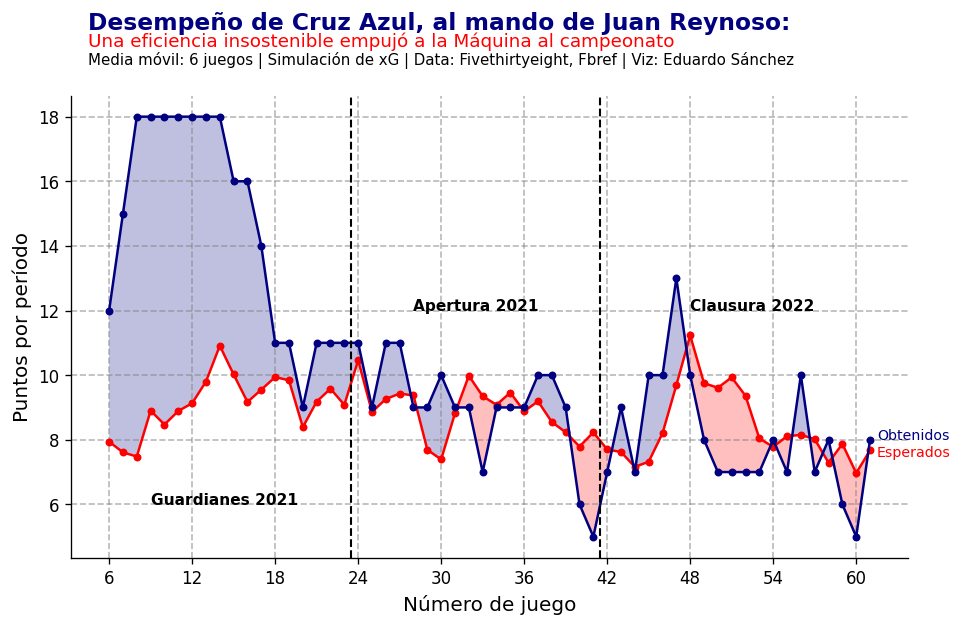

In [55]:
# Período 2018-19

#Figura donde se insertara la grafica
fig= plt.figure(figsize= (9,5), dpi= 120)
ax= plt.subplot(111, facecolor= "white")

# Formato del contorno de figura y líneas de división de ejes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

# Promedio por partido

# Puntos esperados en el período del Aprtura 2018 al despido de Pedro Caixinha

y = df[(df['Torneo'].isin(['G-21','A-21', 'C-22']))]['xpts'].rolling(window=6).sum()
y = y[~(np.isnan(y))].reset_index(drop=True)
y.index = y.index+6

# Calculamos la variable x
x = pd.Series(range(len(y)))+6

# Gráfico de puntos esperados

ax.plot(x,y, lw=1.5, marker='o', ms=3.75, color='red')

# Puntos obtenidos en el período del Apertura 2018 al despido de Pedro Caixinha

y1 = df[(df['Torneo'].isin(['G-21', 'A-21', 'C-22']))]['pts'].rolling(window=6).sum()
y1 = y1[~(np.isnan(y1))].reset_index(drop=True)
y1.index = y1.index+6

# Gráfico de puntos obtenidos

ax.plot(x,y1, lw=1.5, marker='o', ms=3.75, color='navy')

# Relleno de las gráficas

ax.fill_between(x,
                y, 
                y1, where= y< y1,
                facecolor= 'navy', 
                alpha=0.25,
                interpolate=True)
ax.fill_between(x,
                y, 
                y1, 
                where= y>=y1,
                facecolor='red', 
                alpha=0.25,
                interpolate=True)

# Texto para identificar las líneas

ax.text(x.iloc[-1]+0.5, y.iloc[-1]-0.2, s='Esperados', fontsize=8.5, color='red')

ax.text(x.iloc[-1]+0.5, y1.iloc[-1], s='Obtenidos', fontsize=8.5, color='navy')


# Título del gráfico

ax.text(x.min()*0.75, y1.max()*1.15, s='Desempeño de Cruz Azul, al mando de Juan Reynoso:', fontsize=14, color='navy', fontweight='bold')

# Subtítulo

ax.text(x.min()*0.75, y1.max()*1.12, s='Una eficiencia insostenible empujó a la Máquina al campeonato', fontsize=11, color='red')

#Referencias

ax.text(x.min()*0.75, y1.max()*1.09, s='Media móvil: 6 juegos | Simulación de xG | Data: Fivethirtyeight, Fbref | Viz: Eduardo Sánchez', fontsize=9, color='black')


# Línea divisora de torneos
ax.axvline(23.5, ls='--', lw=1.25, color='black')
ax.axvline(41.5, ls='--', lw=1.25, color='black')

# Ajuste de los parametros del eje x

ax.set_xticks(np.arange(6, 63, 6))


# Texto para identificar torneos

ax.text(9,6, s='Guardianes 2021', fontsize=9.25, color='black', fontweight='bold')
ax.text(28,12, s='Apertura 2021', fontsize=9.25, color='black', fontweight='bold')
ax.text(48,12, s='Clausura 2022', fontsize=9.25, color='black', fontweight='bold')


# Títulos de eje

ax.set_xlabel('Número de juego', fontsize=12)
ax.set_ylabel('Puntos por período', fontsize=12)